In [2]:
# Using AMPTorch 0.1
!pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
  Using cached nibabel-3.2.2-py3-none-any.whl (3.3 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

#np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
#tf.random.set_seed(42)

In [ ]:
images_paths = glob.glob('/project/ds6050-soa2wg/team_lambda_II/Outputs/ccs/filt_global/func_mean/*')

num_im = len(images_paths)
image_array = []

In [5]:
final_list = []
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue
    
image_array = np.array(image_array)

In [6]:
image_array.shape

(416, 61, 73, 61)

In [7]:
final = []
for path in final_list:
    sub = path.split('/')[-1].split('_func')[0]
    final.append(sub)
subjects = pd.DataFrame(final, columns = ['FILE_ID'])

In [8]:
subjects

,FILE_ID
0,UM_1_0050336
1,Yale_0050609
2,Olin_0050121
3,NYU_0050997
4,UM_1_0050361
...,...
411,UCLA_1_0051217
412,Stanford_0051162
413,Pitt_0050022
414,NYU_0051042


In [9]:
# load in pheno
pheno = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/CasesvsControls.csv', sep = ',')
merged = pheno.merge(subjects, on = 'FILE_ID')
pheno = np.array(merged['DX_GROUP'])
pheno = np.where(pheno == 2, 0, pheno) #adjust 2's (control) to 0 (negative case)

In [10]:
pheno.shape

(416,)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(image_array, pheno, test_size = 0.3, random_state = 144444)

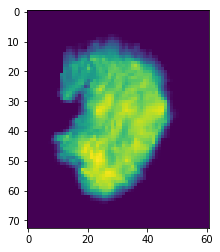

In [12]:
plt.imshow(image_data[45])

Mostly implementing this example
https://keras.io/examples/vision/3D_image_classification/

In [13]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [14]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# GauGAN

https://keras.io/examples/generative/gaugan/